## Tutorial 1 Querying niches on simulation data

To evaluate the niche query performance under niche-level topological and environmental variations, we simulated a spatial transcriptomics dataset with two samples with scCube. 

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import sys
import logging
import warnings
import scanpy as sc
import matplotlib.pyplot as plt

In [2]:
import quest.utils as utils
from quest.trainer import QueSTTrainer

In [3]:
warnings.filterwarnings("ignore")
logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)

### Read and explore the data

In [4]:
data_path = "../data/Simulation"
model_path = "../results/Simulation/model/quest_model.pth"
sample_ids = ["Sample1", "Sample2"]
adata_list = [sc.read_h5ad(f"{data_path}/{data_id}.h5ad") for data_id in sample_ids]

In each sample, we first simulated heterogeneous background cell types. Sample-1 (S1) featured endothelial cells, while Sample-2 (S2) featured macrophage/monocyte cells as backgrounds. Then, we created three niche types within the background. The key differences between these niches lay in cell type composition (Type-1 & Type-2 vs. Type-3) and topological structure (Type-1 vs. Type-2). Type-1 niches had Cancer/Epithelial cells at the inner core and T-cells in the outer edge; Type-2 niches had the reverse structure, with T-cells at the inner core and Cancer/Epithelial cells in the outer edge; Type-3 niches consisted of Cancer/Epithelial cells at the inner core and B-cells in the outer edge. Here we show the query niches on Sample1 and their corresponding target niches on Sample2.

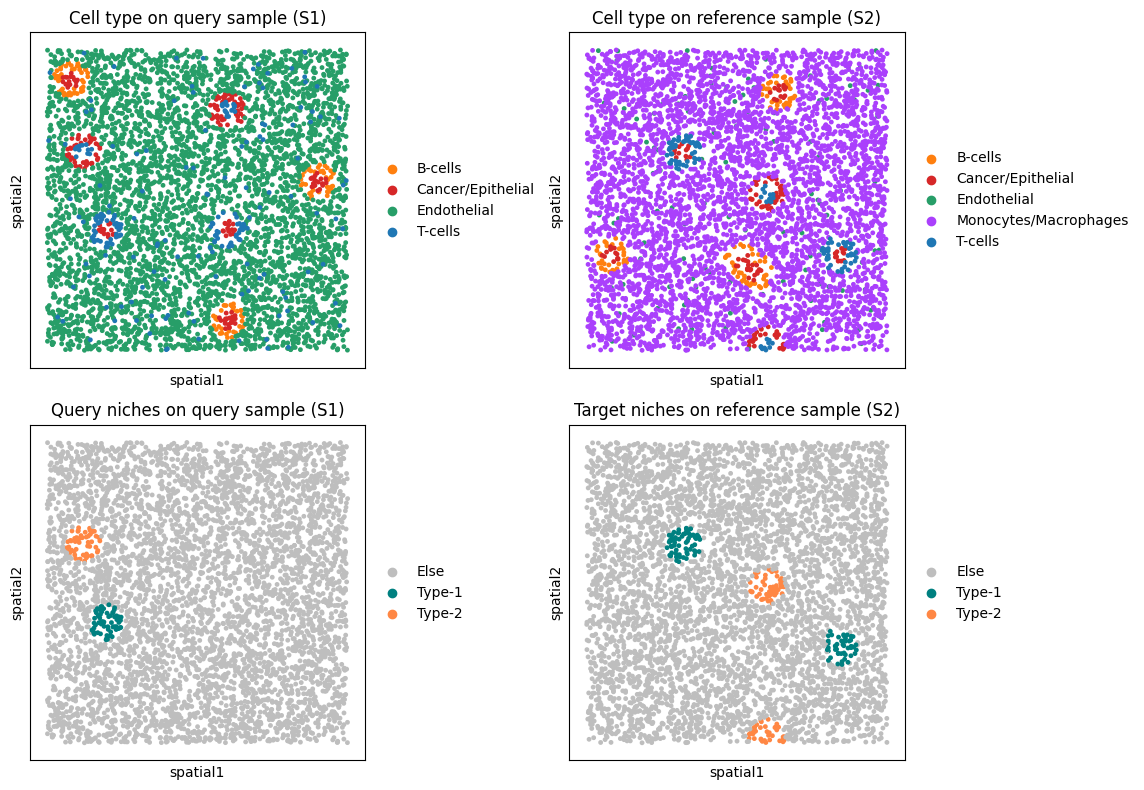

In [5]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(12, 8))
axes = axes.flatten()
adata_query, adata_ref = adata_list[0], adata_list[1]
sc.pl.spatial(adata_query, color="cell_type", spot_size=0.8, ax=axes[0], show=False, title="Cell type on query sample (S1)", palette=utils.color_simulation)
sc.pl.spatial(adata_ref, color="cell_type", spot_size=0.8, ax=axes[1], show=False, title="Cell type on reference sample (S2)", palette=utils.color_simulation)
sc.pl.spatial(adata_query, color="query niche", spot_size=0.8, ax=axes[2], show=False, title="Query niches on query sample (S1)", palette=utils.color_simulation)
sc.pl.spatial(adata_ref, color="target niche", spot_size=0.8, ax=axes[3], show=False, title="Target niches on reference sample (S2)", palette=utils.color_simulation)
fig.tight_layout()
fig.show()

### Configure niche query task

In [6]:
dataset = "Simulation"
query_sample_id = "Sample1"
query_niches = ['Type-1_niche', 'Type-2_niche']

### Set up QueST Trainer

Since scCube directly simulated normalized gene expression, normalization is not needed here.

In [7]:
trainer = QueSTTrainer(dataset=dataset, data_path=data_path, sample_ids=sample_ids, adata_list=adata_list, 
                       query_niches=query_niches, query_sample_id=query_sample_id, 
                       model_path=model_path, 
                       epochs=20, save_model=True, hvg=None, min_count=0, normalize=False)

INFO:quest.trainer:Processing arguments, time: 2025/11/01 17:05:34
INFO:quest.trainer:QueST Trainer initialized, loading data, time: 2025/11/01 17:05:34
INFO:quest.trainer:Data loaded with 2 adata objects, time: 2025/11/01 17:05:34


### Train QueST model

In [8]:
trainer.train()

INFO:quest.trainer:adata Sample1 has existing graph
INFO:quest.trainer:adata Sample2 has existing graph
INFO:quest.utils:preprocessing adata, selecting common features
INFO:quest.utils:gene num before intersection: [2000, 2000]
INFO:quest.utils:2000 common genes identified
INFO:quest.utils:gene num after intersection: [2000, 2000]
INFO:quest.utils:filtering genes with min count=0
INFO:quest.utils:1280 genes passed the filter with min count > 0, making adata copies
INFO:quest.utils:Skip normalizing count
INFO:quest.utils:Constructing spatial graph, computing 3-hop subgraph and creating batch labels for each sample! Batch num: 2
INFO:quest.utils:getting feature: gene expression
INFO:quest.utils:computing 3 hop subgraph for sample Sample1, time: 2025/11/01 17:05:35
 10%|▉         | 485/5000 [00:00<00:05, 753.01it/s]

100%|██████████| 5000/5000 [00:04<00:00, 1050.30it/s]
INFO:quest.utils:getting feature: gene expression
INFO:quest.utils:computing 3 hop subgraph for sample Sample2, time: 2025/11/01 17:05:40
100%|██████████| 5000/5000 [00:04<00:00, 1248.39it/s]
INFO:quest.trainer:initializing QueST object
INFO:quest.trainer:Epoch: 0, Batch: 1/2, Sample: Sample1, Time: 2025/11/01 17:05:44
INFO:quest.trainer:********** discriminator step **********
INFO:quest.trainer:Epoch 0 Sample Sample1: loss disc: 0.764
INFO:quest.trainer:********** generator step **********
INFO:quest.utils:total nodes: 5000, fixed center: 100, total fixed nodes: 2870, k list: Counter({3: 100})
INFO:quest.utils:selecting subgraphs
INFO:quest.utils:1119 out of 2130 nodes with shuffle ratio in range [0.25, 0.75] selected as negative samples
INFO:quest.trainer:Epoch 0 Sample Sample1: loss mse: 1.892, loss gen: 0.764, loss positive: 1.200, loss negative: 0.489, loss total: 4.345
INFO:quest.trainer:Epoch: 0, Batch: 2/2, Sample: Sample2,

### Use trained QueST model to perform niche query

In [9]:
trainer.inference(save_embedding=False, query=True)

INFO:quest.trainer:Loading model, time: 2025/11/01 17:07:31
INFO:quest.trainer:Performing query: q_id=Sample1, q_niche=Type-1_niche, time: 2025/11/01 17:07:32
INFO:quest.trainer:Processing Sample2, saving predicted niche matching score to Anndata
INFO:quest.trainer:Performing query: q_id=Sample1, q_niche=Type-2_niche, time: 2025/11/01 17:07:33
INFO:quest.trainer:Processing Sample2, saving predicted niche matching score to Anndata


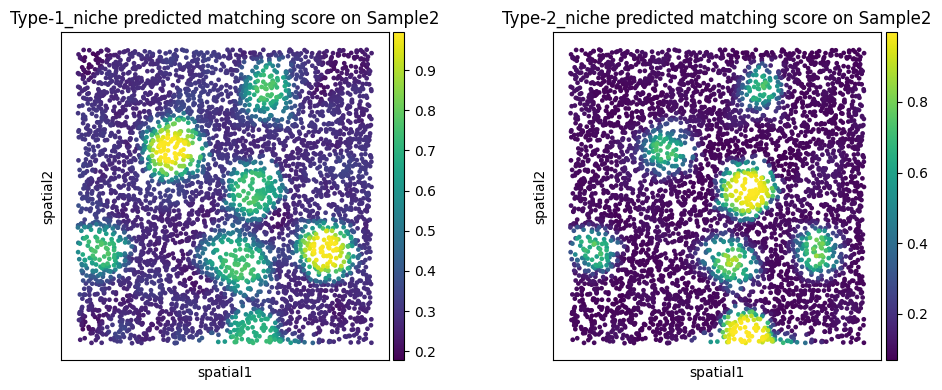

In [10]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10, 4))
axes = axes.flatten()
adata_ref = trainer.adata_ref_list[0]
for i, query_niche in enumerate(query_niches):
    sc.pl.spatial(adata_ref, color=f"{query_niche} predicted matching score", ax=axes[i], show=False, spot_size=0.8, title=f"{query_niche} predicted matching score on Sample2")
fig.tight_layout()
fig.show()